# Deep Learning Project 2 - Computer Vision Multi-Classification and                                                                  Multi-Layer Neural Network Models
Previously, pickle files were formatted datasets for training, development and testing on the notMNIST dataset.
The goal of this project is to progressively train deeper and more accurate models using TensorFlow.

In [2]:
# Import required modules 
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from time import time
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

C:\Users\trevo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



First reload the pre-processed datasets that was generated previously.  

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  sanitized_train_dataset = save['sanitized_train_dataset']
  sanitized_train_labels = save['sanitized_train_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Sanitized Training set', sanitized_train_dataset.shape, sanitized_train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Sanitized Training set (195307, 28, 28) (195307,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat datasets into shapes to support the model algorithms: feature data as a flat matrix; labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  # Flatten image arrays into 1D arrays. Another flatten option uses the np array
  # raveled method in project 1 logistic regression model pre-processing 
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # 1-hot encodings for classifier labels
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  # labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  # Alternate 1-hot encodings implementation
  # Establish np array based on the size (shape) of the label dataset and the number of classification labels
  # .shape returns shape tuple object; .shape[] returns shape integer values
  label_one_hot_array = np.zeros((labels.shape[0],num_labels))
  # Set the np array location value to one (1) based on the label classifer value
  label_one_hot_array[np.arange(labels.shape[0]),labels]=1.0
  # Update labels np array with one_hot_encoding array
  labels = label_one_hot_array
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


First a multi-classification logistic regression algorithm will be BATCHED trained using simple gradient descent.


In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data as Tensorflow constants that are
  # attached to the graph for batch training
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution.
  weights = tf.Variable( tf.truncated_normal([image_size * image_size, num_labels]))
  # The biases get initialized to zero based on the number of labels.
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # Mutltiply the inputs with the weight matrix, and add biases. 
  logits = tf.add(tf.matmul(tf_train_dataset, weights),biases)

  # Then, compute the softmax and cross-entropy 
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Define the Optimizer 
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

 Run this computation and iterate

In [6]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 16.199747
Training accuracy: 16.6%
Validation accuracy: 19.1%
Loss at step 100: 2.329664
Training accuracy: 71.7%
Validation accuracy: 70.6%
Loss at step 200: 1.849432
Training accuracy: 75.1%
Validation accuracy: 72.9%
Loss at step 300: 1.597965
Training accuracy: 76.3%
Validation accuracy: 73.6%
Loss at step 400: 1.432955
Training accuracy: 77.2%
Validation accuracy: 74.0%
Loss at step 500: 1.312914
Training accuracy: 77.8%
Validation accuracy: 74.2%
Loss at step 600: 1.219750
Training accuracy: 78.4%
Validation accuracy: 74.4%
Loss at step 700: 1.144350
Training accuracy: 78.9%
Validation accuracy: 74.6%
Loss at step 800: 1.081616
Training accuracy: 79.5%
Validation accuracy: 74.7%
Test accuracy: 82.4%


Mini-BATCH stochastic gradient descent training which converges much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.506784
Minibatch accuracy: 3.9%
Validation accuracy: 6.9%
Minibatch loss at step 500: 1.351603
Minibatch accuracy: 77.3%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.392477
Minibatch accuracy: 75.0%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 0.868113
Minibatch accuracy: 81.2%
Validation accuracy: 77.0%
Minibatch loss at step 2000: 0.763967
Minibatch accuracy: 85.9%
Validation accuracy: 77.6%
Minibatch loss at step 2500: 0.960233
Minibatch accuracy: 77.3%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 0.941645
Minibatch accuracy: 76.6%
Validation accuracy: 79.3%
Test accuracy: 86.7%


Turn the logistic regression model algorithm with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. 

In [9]:
"""Establish Subset of Training Data for neural network"""
train_subset_size = 10000
train_sub_dataset = train_dataset[:train_subset_size, :]
train_sub_labels = train_labels[:train_subset_size]

In [10]:
"""Establish graph session placeholders for unsanitized dataset"""

# Declare feature data placeholder
x_data = tf.placeholder(shape = [train_sub_dataset.shape[1]], dtype=tf.float32)

# Declare target placeholder
y_target = tf.placeholder(shape = [1,train_sub_labels.shape[1]], dtype=tf.float32)

# Establish 2D vector for the model input data
x_data_2D = tf.expand_dims(x_data,0)

In [11]:
"""Define functions for initializing hidden layer weights and bias variables"""

def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return (weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return (bias)

In [12]:
"""Define function for fully connecting hidden layers with rectified linear unit (ReLU) activation function
    TensorFlow ML Cookbook p 172"""

def fully_connect(input_layer, weights, biases, activation):
    layer = tf.add(tf.matmul(input_layer, weights),biases)
    if (activation == True):
        # Apply ReLU activation functions only for hidden layer output
        return (tf.nn.relu(layer))
    else:
        # Sigmoid activation function applied with loss function for output layer
        return (layer)

In [13]:
"""Define the training model algorithm for single layer artifical neural network with unsanitized dataset"""

# Define number of layer hidden nodes
layer_1_nodes = 1024

# Create first layer with 1024 hidden nodes bases on the image sizes (data dataset)
weight_1 = init_weight(shape= [train_sub_dataset.shape[1],layer_1_nodes], st_dev = 10.0)
bias_1 = init_bias(shape= [layer_1_nodes], st_dev = 10.0)
layer_1_activate = fully_connect(x_data_2D, weight_1, bias_1, activation = True)


# Create output layer based on the number of classification labels (training labels dataset)
weight_output = init_weight(shape= [layer_1_nodes, train_labels.shape[1]], st_dev = 10.0)
bias_output = init_bias(shape= [1,train_labels.shape[1]], st_dev = 10.0)
model_output_logits = fully_connect(layer_1_activate, weight_output, bias_output, activation = False)

# Establish learning rate
learning_rate = 0.001

# Define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = model_output_logits))

# Define optimizer function

my_opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_step = my_opt.minimize(loss)

# Prediction Function
prediction = tf.sigmoid(model_output_logits)

In [14]:
"""Establish graph session for stochastic training for image classification with the unsanitized"""

# logistic regression model algorithm

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


# Define loss and training accuracy lists variables
loss_vec_list = []
train_acc_all_list = []
train_acc_avg_list = []

print('Train Model Over {} Images'.format(train_sub_dataset.shape[0]))

# loop for graph training session
for ix, t in enumerate(train_sub_dataset):
    # Establish training target data as a 2D np arrary for a session placeholder
    y_data = np.array([train_sub_labels[ix]])
    # Run stochastic graph training session
    sess.run(train_step, feed_dict = {x_data:t, y_target:y_data})
    # Run graph session to determine loss function for each generation
    temp_loss = sess.run(loss, feed_dict = {x_data:t, y_target:y_data})
    # Save generation loss value in list
    loss_vec_list.append(temp_loss)
    # Make single prediction
    [temp_pred] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    train_acc_temp = train_sub_labels[ix]==np.round(temp_pred)
    train_acc_all_list.append(train_acc_temp)
    # Keeep trailing average of past 50 accuracy observations
    if (len(train_acc_all_list) >= 50):
        train_acc_avg_list.append(np.mean(train_acc_all_list[-50:]))
    # Display training outcome results from each 250 set of generation
    if ((ix+1)%250 == 0):
        print('Training Observation #{} Loss = {}'.format((ix+1), temp_loss))
        
            
# Display training accuracy results
print('Overall Training Accuracy: {}'.format(np.mean(train_acc_all_list)))

Train Model Over 10000 Images
Training Observation #250 Loss = 3444.25732421875
Training Observation #500 Loss = 0.0
Training Observation #750 Loss = 5902.67529296875
Training Observation #1000 Loss = 1.0445242534785286e-28
Training Observation #1250 Loss = 0.0
Training Observation #1500 Loss = 750.764404296875
Training Observation #1750 Loss = 0.0
Training Observation #2000 Loss = 0.0
Training Observation #2250 Loss = 183.94268798828125
Training Observation #2500 Loss = 0.0
Training Observation #2750 Loss = 5288.94873046875
Training Observation #3000 Loss = 108.20601654052734
Training Observation #3250 Loss = 19.477169036865234
Training Observation #3500 Loss = 139.33685302734375
Training Observation #3750 Loss = 792.3591918945312
Training Observation #4000 Loss = 2239.9921875
Training Observation #4250 Loss = 0.0
Training Observation #4500 Loss = 2099.8291015625
Training Observation #4750 Loss = 0.0
Training Observation #5000 Loss = 0.0
Training Observation #5250 Loss = 647.407043457

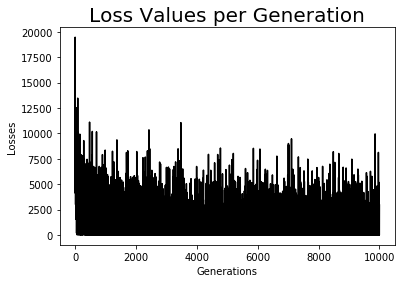

In [15]:
"""Visualize model loss values"""

#Plot Losses
plt.plot(loss_vec_list, 'k-')
plt.title('Loss Values per Generation', fontsize = 20)
plt.xlabel('Generations')
plt.ylabel('Losses')
plt.show()

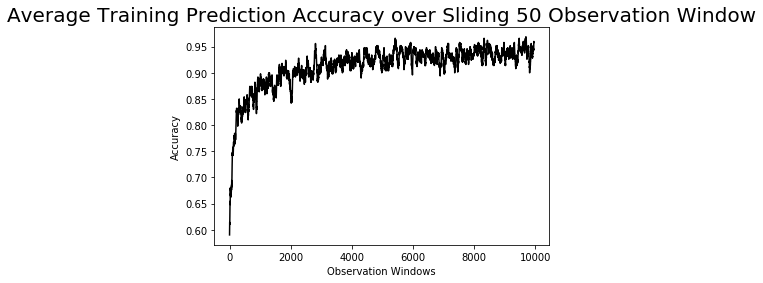

In [16]:
"""Visualize training prediction accurary"""

#Plot Losses
plt.plot(train_acc_avg_list, 'k-')
plt.title('Average Training Prediction Accuracy over Sliding 50 Observation Window', fontsize = 20)
plt.xlabel('Observation Windows')
plt.ylabel('Accuracy')
plt.show()

In [17]:
"""Establish graph session for 1 - Layer neural network model validation testing post unsanitized dataset training"""

# Define validation accuracy lists variable
test_acc_all_list = []

print('Validation Testings Over {} Images'.format(test_dataset.shape[0]))

# loop graph session for NLP logistic regression model validation testing
for ix, t in enumerate(test_dataset):
    # Establish test target data as 2D np.array for session placeholder
    y_data = np.array([test_labels[ix]])
    # Make single prediction
    [temp_pred] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    test_acc_temp = test_labels[ix]==np.round(temp_pred)
    test_acc_all_list.append(test_acc_temp)
  
            
# Display validation accuracy results
print('Overall Validation Accuracy: {}'.format(np.mean(test_acc_all_list)))

Validation Testings Over 10000 Images
Overall Validation Accuracy: 0.94262


In [18]:
"""Reformat sanitized datasets and labels (no duplicate images between the training/validate/test) into shapes to support the 
model algorithms: feature data as a flat matrix; labels as float 1-hot encodings"""

sanitized_train_dataset, sanitized_train_labels = reformat(sanitized_train_dataset, sanitized_train_labels)
print('Sanitized Training set', sanitized_train_dataset.shape, sanitized_train_labels.shape)

Sanitized Training set (195307, 784) (195307, 10)


In [54]:
"""Establish Subset of Sanitized Training Data for neural network"""
sanit_train_subset_size = 5000
sanit_train_sub_dataset = sanitized_train_dataset[:sanit_train_subset_size, :]
sanit_train_sub_labels = sanitized_train_labels[:sanit_train_subset_size]

In [55]:
"""Establish graph session placeholders for sanitized dataset"""

# Declare feature data placeholder
x_data = tf.placeholder(shape = [sanit_train_sub_dataset.shape[1]], dtype=tf.float32)

# Declare target placeholder
y_target = tf.placeholder(shape = [1,sanit_train_sub_labels.shape[1]], dtype=tf.float32)

# Establish 2D vector for the model input data
x_data_2D = tf.expand_dims(x_data,0)

In [56]:
"""Define the training model algorithm for single layer artifical neural network with sanitized dataset"""

# Define number of layer hidden nodes
layer_1_nodes = 1024

# Create first layer with 1024 hidden nodes bases on the image sizes (data dataset)
weight_1 = init_weight(shape= [sanit_train_sub_dataset.shape[1],layer_1_nodes], st_dev = 10.0)
bias_1 = init_bias(shape= [layer_1_nodes], st_dev = 10.0)
layer_1_activate = fully_connect(x_data_2D, weight_1, bias_1, activation = True)


# Create output layer based on the number of classification labels (training labels dataset)
weight_output = init_weight(shape= [layer_1_nodes, sanit_train_sub_labels.shape[1]], st_dev = 10.0)
bias_output = init_bias(shape= [1,sanit_train_sub_labels.shape[1]], st_dev = 10.0)
model_output_logits = fully_connect(layer_1_activate, weight_output, bias_output, activation = False)

# Establish learning rate
learning_rate = 0.001

# Define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = model_output_logits))

# Define optimizer function

my_opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_step = my_opt.minimize(loss)

# Prediction Function
prediction = tf.sigmoid(model_output_logits)

In [57]:
"""Establish graph session for stochastic training for image classification with the sanitized"""

# logistic regression model algorithm

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


# Define loss and training accuracy lists variables
loss_vec_list = []
train_acc_all_list = []
train_acc_avg_list = []

print('Train Model Over {} Images'.format(sanit_train_sub_dataset.shape[0]))

# loop for graph training session
for ix, t in enumerate(sanit_train_sub_dataset):
    # Establish training target data as a 2D np arrary for a session placeholder
    y_data = np.array([sanit_train_sub_labels[ix]])
    # Run stochastic graph training session
    sess.run(train_step, feed_dict = {x_data:t, y_target:y_data})
    # Run graph session to determine loss function for each generation
    temp_loss = sess.run(loss, feed_dict = {x_data:t, y_target:y_data})
    # Save generation loss value in list
    loss_vec_list.append(temp_loss)
    # Make single prediction
    [temp_pred] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    train_acc_temp = sanit_train_sub_labels[ix]==np.round(temp_pred)
    train_acc_all_list.append(train_acc_temp)
    # Keeep trailing average of past 50 accuracy observations
    if (len(train_acc_all_list) >= 50):
        train_acc_avg_list.append(np.mean(train_acc_all_list[-50:]))
    # Display training outcome results from each 250 set of generation
    if ((ix+1)%250 == 0):
        print('Sanitized Training Observation #{} Loss = {}'.format((ix+1), temp_loss))
        
            
# Display training accuracy results
print('Overall Sanitized Training Accuracy: {}'.format(np.mean(train_acc_all_list)))

Train Model Over 5000 Images
Sanitized Training Observation #250 Loss = 1736.2015380859375
Sanitized Training Observation #500 Loss = 0.0
Sanitized Training Observation #750 Loss = 0.0
Sanitized Training Observation #1000 Loss = 0.0
Sanitized Training Observation #1250 Loss = 0.0
Sanitized Training Observation #1500 Loss = 0.0
Sanitized Training Observation #1750 Loss = 0.0
Sanitized Training Observation #2000 Loss = 1008.8352661132812
Sanitized Training Observation #2250 Loss = 0.0
Sanitized Training Observation #2500 Loss = 0.0
Sanitized Training Observation #2750 Loss = 0.0
Sanitized Training Observation #3000 Loss = 0.0
Sanitized Training Observation #3250 Loss = 0.0
Sanitized Training Observation #3500 Loss = 0.0
Sanitized Training Observation #3750 Loss = 0.0
Sanitized Training Observation #4000 Loss = 965.4622802734375
Sanitized Training Observation #4250 Loss = 0.0
Sanitized Training Observation #4500 Loss = 0.0
Sanitized Training Observation #4750 Loss = 0.0
Sanitized Training

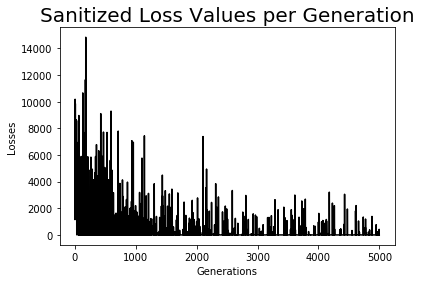

In [58]:
"""Visualize sanitized model loss values"""

#Plot Losses
plt.plot(loss_vec_list, 'k-')
plt.title('Sanitized Loss Values per Generation', fontsize = 20)
plt.xlabel('Generations')
plt.ylabel('Losses')
plt.show()

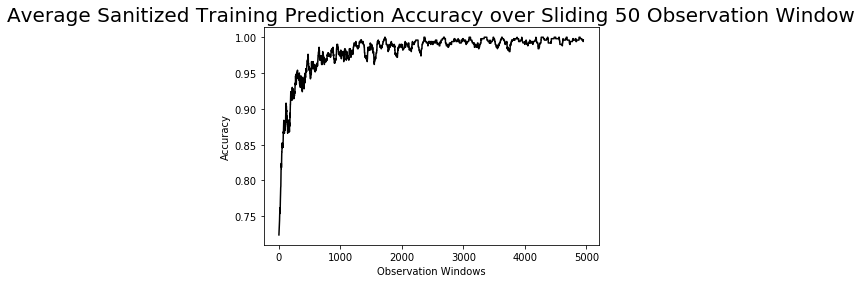

In [59]:
"""Visualize sanitized training prediction accurary"""

#Plot Losses
plt.plot(train_acc_avg_list, 'k-')
plt.title('Average Sanitized Training Prediction Accuracy over Sliding 50 Observation Window', fontsize = 20)
plt.xlabel('Observation Windows')
plt.ylabel('Accuracy')
plt.show()

In [60]:
"""Establish graph session for 1 - Layer neural network model validation testing post sanitized dataset training"""

# Define validation accuracy lists variable
test_acc_all_list = []

print('Validation Testings Over {} Images'.format(test_dataset.shape[0]))

# loop graph session for NLP logistic regression model validation testing
for ix, t in enumerate(test_dataset):
    # Establish test target data as 2D np.array for session placeholder
    y_data = np.array([test_labels[ix]])
    # Make single prediction
    [temp_pred] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    test_acc_temp = test_labels[ix]==np.round(temp_pred)
    test_acc_all_list.append(test_acc_temp)
  
            
# Display validation accuracy results
print('Overall Post Sanitized Validation Accuracy: {}'.format(np.mean(test_acc_all_list)))

Validation Testings Over 10000 Images
Overall Post Sanitized Validation Accuracy: 0.81019
